In [ ]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [ ]:
from vfield import *

vfield = torch.load('data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

In [ ]:
# matplotlib (currently in the NeurIPS submission)
plot_vector_field(grid, displacement)

# LIC
lic_img_loaded = render_lic(grid, displacement, resolution=512, length=30, normalize=True)

In [22]:
import numpy as np
from PIL import Image, ImageDraw
from scipy.interpolate import griddata

def create_flow_field_image(mode='vortex', W=4000, H=4000, N_PART=10_000, STEPS=400, 
                           STEP_SIZE=0.002, ALPHA=2, BG=255, extent=None):
    """
    Create flow field visualization using explicit particle integration
    
    Args:
        mode: 'vortex' (analytic vortex) or 'loaded' (use loaded vector field)
        W, H: canvas size
        N_PART: number of particles
        STEPS: integration steps per particle  
        STEP_SIZE: step size as fraction of image width
        ALPHA: opacity per stroke (0-255)
        BG: background color (0-255)
        extent: spatial extent for loaded mode, tuple (min_x, max_x, min_y, max_y)
    """
    
    if mode == 'loaded' and extent is None:
        # Default extent based on loaded data
        extent = (-10, 10, -10, 10)
    elif mode == 'vortex' and extent is None:
        # Default extent for vortex
        extent = (-1, 1, -1, 1)
    
    min_x, max_x, min_y, max_y = extent
    
    # ------------- vector field -----------
    if mode == 'vortex':
        def F(px, py):
            """Analytic clockwise vortex field"""
            # map pixel → spatial coords
            x = (px/W) * (max_x - min_x) + min_x
            y = (py/H) * (max_y - min_y) + min_y
            return -y, x      # simple vortex
            
    elif mode == 'loaded':
        # Pre-compute interpolation on a dense grid for speed
        grid_np = grid.numpy()
        displacement_np = displacement.numpy()
        
        # Create dense interpolation grid
        interp_res = 512  # Resolution for interpolation grid
        x_interp = np.linspace(min_x, max_x, interp_res)
        y_interp = np.linspace(min_y, max_y, interp_res)
        X_interp, Y_interp = np.meshgrid(x_interp, y_interp, indexing='xy')
        points_interp = np.column_stack((X_interp.ravel(), Y_interp.ravel()))
        
        # Pre-compute interpolated values
        u_grid = griddata(grid_np, displacement_np[:, 0], points_interp, 
                         method='linear', fill_value=0.0).reshape(interp_res, interp_res)
        v_grid = griddata(grid_np, displacement_np[:, 1], points_interp, 
                         method='linear', fill_value=0.0).reshape(interp_res, interp_res)
        
        def F(px, py):
            """Fast lookup from pre-computed interpolation grid"""
            # map pixel → spatial coords
            x = (px/W) * (max_x - min_x) + min_x
            y = (py/H) * (max_y - min_y) + min_y
            
            # Convert to grid indices
            i = int((y - min_y) / (max_y - min_y) * (interp_res - 1))
            j = int((x - min_x) / (max_x - min_x) * (interp_res - 1))
            
            # Bounds check
            if 0 <= i < interp_res and 0 <= j < interp_res:
                return u_grid[i, j], v_grid[i, j]
            else:
                return 0.0, 0.0
    else:
        raise ValueError("Mode must be 'vortex' or 'loaded'")
    
    # ------------- integrate --------------
    img = Image.new("L", (W, H), BG)
    drw = ImageDraw.Draw(img, "L")
    
    rng = np.random.default_rng(0)
    starts_x = rng.uniform(0, W, N_PART)
    starts_y = rng.uniform(0, H, N_PART)

    
    for x0, y0 in zip(starts_x, starts_y):
        x, y = x0, y0
        pts   = []
        for _ in range(STEPS):
            u, v = F(x, y)
            norm = (u*u + v*v)**0.5 + 1e-6
            x   += (u / norm) * STEP_SIZE * W
            y   += (v / norm) * STEP_SIZE * W
            if not (0 <= x < W and 0 <= y < H):
                break
            pts.append((x, y))
        if len(pts) > 1:
            drw.line(pts, fill=BG-ALPHA, width=1)   # low-alpha, additive

    return img

# Create flow field with analytic vortex
print("Creating flow field with analytic vortex...")
img_vortex = create_flow_field_image(mode='vortex', W=1000, H=1000, N_PART=2000)
img_vortex.save("flow_field_vortex.png")

# Create flow field with loaded vector field
print("Creating flow field with loaded vector field...")
img_loaded = create_flow_field_image(mode='loaded', W=1000, H=1000, N_PART=2000, 
                                   extent=(-10, 10, -10, 10))
img_loaded.save("flow_field_loaded.png")

Creating flow field with analytic vortex...
Creating flow field with loaded vector field...
Creating flow field with loaded vector field...


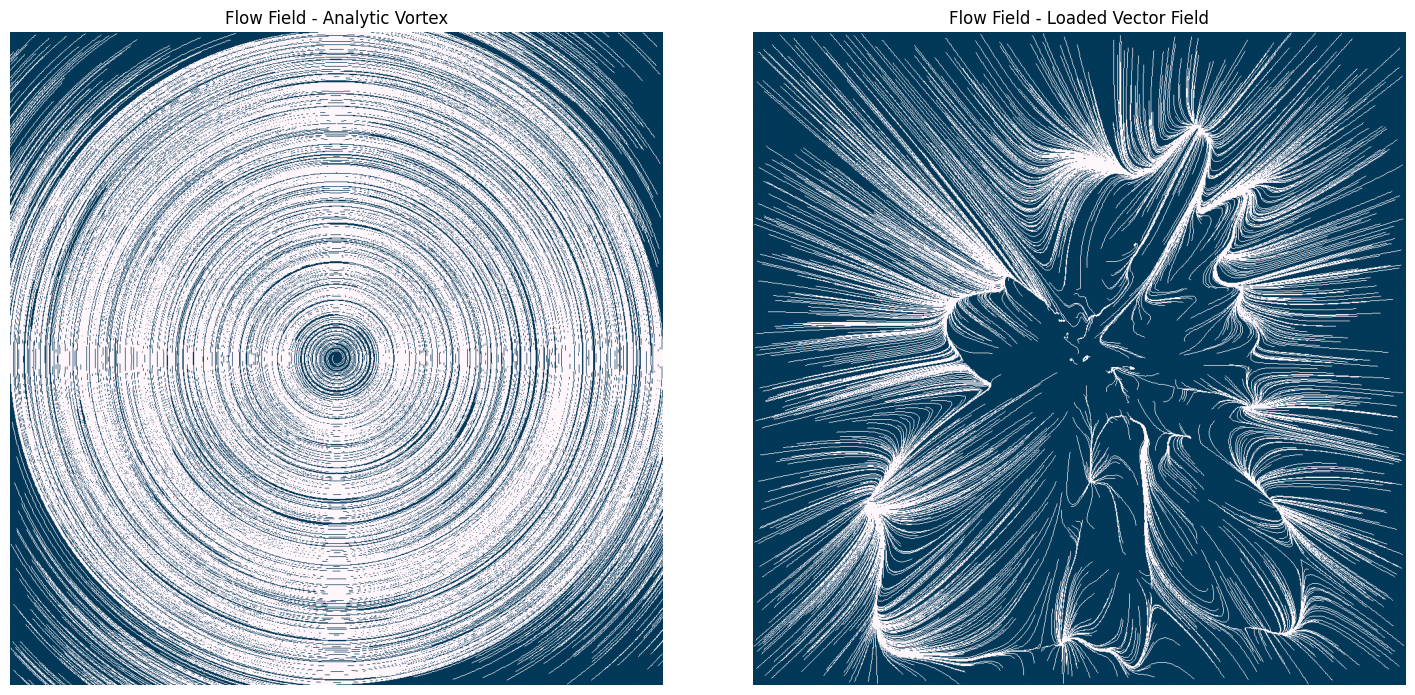

In [23]:
# Display both flow field images
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Display vortex flow field
ax1.imshow(img_vortex, cmap='PuBu', origin='lower')
ax1.set_title('Flow Field - Analytic Vortex')
ax1.axis('off')

# Display loaded vector field flow field
ax2.imshow(img_loaded, cmap='PuBu', origin='lower')
ax2.set_title('Flow Field - Loaded Vector Field')
ax2.axis('off')

plt.tight_layout()
plt.show()